# 3-class classification example

In this example we try to learn a model that is able to classify 3 classes drawn from 3 different normal distributions

In [8]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian

# Dataset Generation

[]

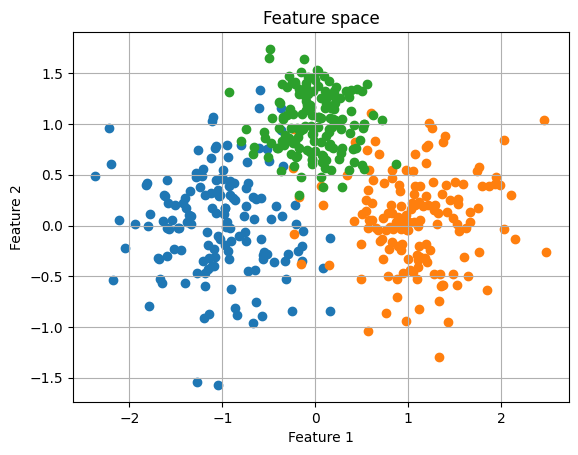

In [9]:
# Generate dataset
N_training = 100
N_validation = 50
N = N_training + N_validation


X0 = np.array([-1, 0]).T + 0.5 * np.random.normal(size=(N, 2))
X1 = np.array([1, 0]).T +  0.5 * np.random.normal(size=(N, 2))
X2 = np.array([0, 1]).T + 0.3 * np.random.normal(size=(N, 2))
X = np.concatenate([X0, X1, X2])

labels = np.zeros((3*N, 1))
labels[N:2*N] = 1
labels[2*N:] = 2

# Training dataset
indices = np.random.permutation(3 * N)
trn_indices, val_indices = indices[:N_training], indices[N_training:]
Tdataset = ([torch.tensor(X[trn_indices], dtype=torch.float32), torch.tensor(labels[trn_indices], dtype=torch.float32)])
Vdataset = ([torch.tensor(X[val_indices], dtype=torch.float32), torch.tensor(labels[val_indices], dtype=torch.float32)])

# Plot dataset
plt.scatter(X0[:, 0], X0[:, 1])
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.grid()
plt.title('Feature space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.plot()

# Define RBF

In [10]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x):
    return torch.norm(x, p=2, dim=-1)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()

rbf = RBFLayer(in_features_dim=2,
               num_kernels=3,
               out_features_dim=3,
               radial_function=rbf_gaussian,
               norm_function=euclidean_norm,
               normalization=True)


# Training code

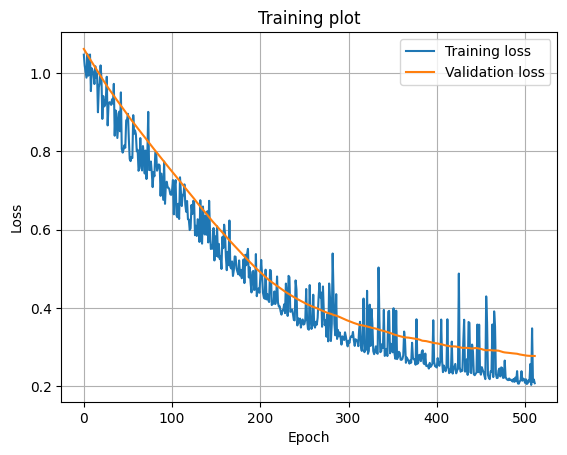

In [11]:
optimiser = torch.optim.Adam(rbf.parameters(), lr=1e-3)
epoch = 0
batch_size = 32
trn_losses = []
val_losses = []

for epoch in range(512):
    indices = np.random.permutation(N_training)
    batch_idx = 0
    epoch_trn_losses = []
    epoch_val_losses = []
    
    # Epoch training
    while batch_idx < N_training:
        idxs = indices[batch_idx:batch_idx + batch_size]
        x = Tdataset[0][idxs]
        labels = Tdataset[1][idxs].flatten()
        
        # Compute loss
        optimiser.zero_grad()
        y = rbf(x)
        loss = nn.CrossEntropyLoss()(y, labels.long())
        epoch_trn_losses.append(loss.item())
        loss.backward()
        optimiser.step()
        batch_idx += batch_size
        
        with torch.no_grad():
            # Compute validation
            x = Vdataset[0]
            labels = Vdataset[1].flatten()
            y = rbf(x)
            loss = nn.CrossEntropyLoss()(y, labels.long())
            epoch_val_losses.append(loss.item())
            
    trn_losses.append(np.mean(epoch_trn_losses))
    val_losses.append(np.mean(epoch_val_losses))

plt.plot(trn_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Training plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Plot kernels